In [1]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

USER = os.environ["USER"]

MAX_THRESHOLD_CONST = 3.50 #CONSTANT WILL BE mean of rats for stim max / threshold for EVERY possible combination... ma.mean(ma.median((stim_max/ma.mean(a, axis=0)),axis = (1,2,3)),axis =0)
NUM_THRESHOLD_POINTS = 500


In [2]:
src = "/home/andres/repos/rat-mapping-paper/reports/L_CIRC/inference.pkl"

with open(src, "rb") as f:
    df, encoder_dict, model, posterior_samples, = pickle.load(f);

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
named_params = [site.a, site.b, site.L, site.ell, site.H]
params = [posterior_samples[param][...] for param in named_params]

for named_param, param in zip(named_params, params):
    print(named_param, param.shape)

a (4000, 8, 21, 6)
b (4000, 8, 21, 6)
L (4000, 8, 21, 6)
ℓ (4000, 8, 21, 6)
H (4000, 8, 21, 6)


In [4]:
min_threshold = ma.min(posterior_samples[site.a], axis=0)

In [7]:
compound_positions = encoder_dict["compound_position"].inverse_transform(sorted(set(df["compound_position"]))).tolist() #sorted(set(df["compound_position"])

In [8]:
vertices = [(i, cpos) for i, cpos in enumerate(compound_positions) if cpos.split("-")[0] == ""]
radii = [(i, cpos) for i, cpos in enumerate(compound_positions) if cpos.split("-")[0] and cpos.split("-")[1] == "C6LC"]
diameters = [(i, cpos) for i, cpos in enumerate(compound_positions) if (i, cpos) not in vertices and (i, cpos) not in radii]

vertices = [i for (i, cpos) in vertices]
radii = [i for (i, cpos) in radii]
diameters = [i for (i, cpos) in diameters]

In [10]:
a = posterior_samples[site.a]
a.shape

(4000, 8, 21, 6)

In [71]:
dia = a[:,:,radii,:]

In [72]:
dia.shape

(4000, 8, 8, 6)

In [73]:
dia = dia.mean(axis = (0))

In [74]:
dia.shape

(8, 8, 6)

In [64]:
(dia[5,:,0]).shape

(8, 6)

In [35]:
subjects = sorted(set(df["participant"]))
positions = sorted(set(df["compound_position"]))
muscles = model.response

In [46]:
diameters

[10, 13, 16, 18]

In [78]:
target_list = []
for s in subjects:
    for m, ind in enumerate(muscles): 
        temp_max = np.max(dia[s,:,m], axis = 0)
        for d in range(len(dia[0,:,0])):
            if dia[s,d,m] == temp_max:
                target = d
        target_list.append(target)

stats.mode(target_list)

ModeResult(mode=0, count=20)

ModeResult(mode=0, count=20)

In [77]:
encoder_dict["compound_position"].inverse_transform(radii)

array(['C6LE-C6LC', 'C6LN-C6LC', 'C6LNE-C6LC', 'C6LNW-C6LC', 'C6LS-C6LC',
       'C6LSE-C6LC', 'C6LSW-C6LC', 'C6LW-C6LC'], dtype=object)

In [10]:
subjects = sorted(set(df["participant"]))
positions = sorted(set(df["compound_position"]))
muscles = model.response

In [11]:
positions

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [8]:
stim_max = []

for s in subjects:
    for p in positions:
        for m in muscles: 
            temp = df[(df['participant'] == s) 
                    & (df['compound_position'] == p) 
                    ]
            temp = temp.loc[:,[m, 'pulse_amplitude']]
            temp = temp.pulse_amplitude.max()
            stim_max.append(temp)

stim_max = ma.array(stim_max)
stim_max = stim_max.reshape(len(subjects), len(positions), len(muscles))
            

In [9]:
a = posterior_samples[site.a]
a.shape

(4000, 8, 21, 6)

In [10]:
(stim_max/ma.mean(a, axis=0)).shape

(8, 21, 6)

In [11]:
ma.mean(ma.median((stim_max/ma.mean(a, axis=0)),axis = (1,2)),axis =0)

3.5009097655044012

In [12]:
param.shape

(4000, 8, 21, 6)

In [14]:
def get_normalized_input_output(subset):
    norm_y = []
    norm_x = []

    for subject_ind, subject in enumerate(subjects):
        curr_params = [
            param[:, subject_ind, subset, :][:, :, :, None] for param in params
        ]
        # Take nanmean across posterior samples 
        temp = np.nanmean(curr_params[0], axis=0)
        # Take nanmedian across compound positions and muscles
        median_threshold = np.nanmedian(temp)
        
        x_temp = np.linspace(0.,  median_threshold * MAX_THRESHOLD_CONST, NUM_THRESHOLD_POINTS)
        x_temp = x_temp[None, None, None, :]

        temp_thresh = F.rectified_logistic(
            x_temp,
            *curr_params
        )
        # Remove offset
        temp_thresh = temp_thresh - curr_params[2]
        
        norm_y.append(temp_thresh)
        norm_x.append(x_temp)

    norm_x = np.array(norm_x)
    norm_y = np.array(norm_y)
    norm_y = ma.masked_invalid(norm_y)
    
    return norm_x, norm_y



In [42]:
x, y = get_normalized_input_output(vertices)



In [43]:
y.shape

(8, 4000, 9, 6, 500)

In [44]:
y_max = ma.max(y, axis=(2, -1), keepdims=True)


In [45]:
y = ma.where(y_max, y / y_max, 0.)

In [46]:
p = ma.sum(y, axis=-2, keepdims=True)


In [47]:
p = ma.where(p, y / p, 1 / y.shape[-2])

In [48]:
plogp = ma.where(p, p * ma.log(p), 0.)

In [49]:
entropy = 1 + (plogp.sum(axis=-2) / ma.log(y.shape[-2]))

In [ ]:
auc = np.trapz(y=entropy[...], x=np.linspace(0, MAX_THRESHOLD_CONST, NUM_THRESHOLD_POINTS), axis=-1)
auc.shape

(8, 4000, 9)

In [51]:
auc = auc.mean(axis=(1))
auc.shape

(8, 9)

In [52]:
mat = auc[:, :, None] - auc[:, None, :]

In [53]:
mat.shape

(8, 9, 9)

In [12]:
vertices

[0, 1, 2, 3, 4, 5, 6, 7, 8]

<Axes: >

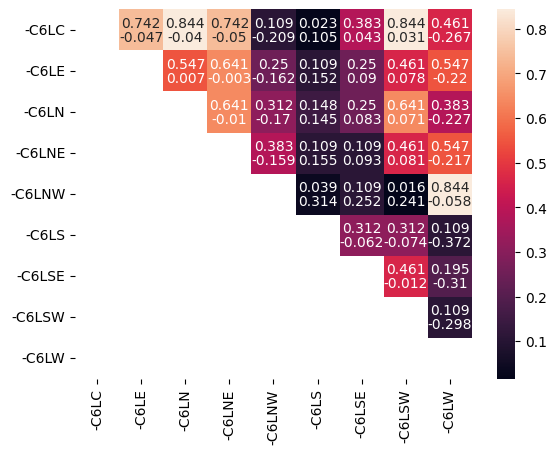

In [54]:
pvalues = []
for i in range(len(vertices)):
    for i2 in range(len(vertices)):
        if i==i2:
            pvalues.append(1)
            continue
        temp_p = stats.wilcoxon(mat[:,i,i2], axis=0).pvalue
        pvalues.append(temp_p)

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(len(vertices), len(vertices))

labels = encoder_dict["compound_position"].inverse_transform(vertices)
mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(mat.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)